StellarMasses : 114685
visualMorph : 38795
visualMorph Ellipticals: 3053


Joining Visual Morph 1908
1908


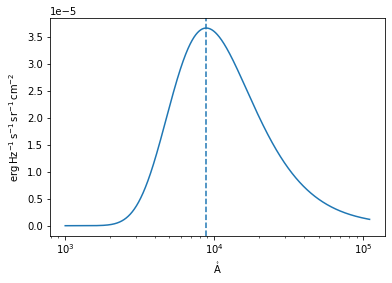

True model values
  T1 = 5000.00
  T2 = 8000.00
Parameters of best-fitting model:
  T1 = 7932.53 +/- 102.35
  T2 = 5192.46 +/- 451.14
98 dof
chi squared 78.29
nchi2 0.80


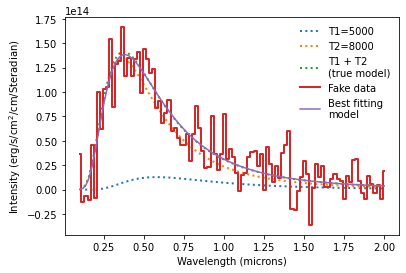

In [7]:
from astropy.table import Table, join
from scipy import stats
#import seaborn as sns
#import pandas as pd
import statistics as st

StellarMasses = Table.read('../../GAMA_DATA/StellarMassesv19.fits')
# Clean Data
#StellarMasses = StellarMasses[StellarMasses['uminusr'] > 0.001]
#StellarMasses = StellarMasses[StellarMasses['logmstar'] > 0.001]
#StellarMasses = StellarMasses[StellarMasses['metal'] > 0.001]

StellarMasses = StellarMasses[StellarMasses['uminusr'] > 0.01]
StellarMasses = StellarMasses[StellarMasses['logmstar'] > 0.01]
StellarMasses = StellarMasses[StellarMasses['metal'] > 0.01]
print(f"StellarMasses : {len(StellarMasses)}")

visualMorph = Table.read('../../GAMA_Data/VisualMorphologyv03.fits')
print(f"visualMorph : {len(visualMorph)}")
## Clean Data
visualMorphElliptical = visualMorph[visualMorph['ELLIPTICAL_CODE'] == 1]
#visualMorphSpiral = visualMorph[visualMorph['ELLIPTICAL_CODE'] == 10]
print(f"visualMorph Ellipticals: {len(visualMorphElliptical)}")

RErange = join(StellarMasses,visualMorphElliptical,keys='CATAID',join_type='inner')
print('Joining Visual Morph '+str(len(RErange)))
print(len(RErange))

from astropy.modeling import models
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt

from astropy.modeling.models import BlackBody
from astropy import units as u
from astropy.visualization import quantity_support

bb = BlackBody(temperature=5778*u.K)
wav = np.arange(1000, 110000) * u.AA
flux = bb(wav)

with quantity_support():
    plt.figure()
    plt.semilogx(wav, flux)
    plt.axvline(bb.nu_max.to(u.AA, equivalencies=u.spectral()).value, ls='--')
    plt.show()
    
    
from scipy.optimize import curve_fit
#import pylab as plt
#import numpy as np

def blackbody_lam(lam, T):
    """ Blackbody as a function of wavelength (um) and temperature (K).

    returns units of erg/s/cm^2/cm/Steradian
    """
    from scipy.constants import h,k,c
    lam = 1e-6 * lam # convert to metres
    return 2*h*c**2 / (lam**5 * (np.exp(h*c / (lam*k*T)) - 1))

wa = np.linspace(0.1, 2, 100)   # wavelengths in um
T1 = 5000.
T2 = 8000.
y1 = blackbody_lam(wa, T1)
y2 = blackbody_lam(wa, T2)
ytot = y1 + y2

np.random.seed(1)

# make synthetic data with Gaussian errors

sigma = np.ones(len(wa)) * 1 * np.median(ytot)
ydata = ytot + np.random.randn(len(wa)) * sigma

# plot the input model and synthetic data

plt.figure()
plt.plot(wa, y1, ':', lw=2, label='T1=%.0f' % T1)
plt.plot(wa, y2, ':', lw=2, label='T2=%.0f' % T2)
plt.plot(wa, ytot, ':', lw=2, label='T1 + T2\n(true model)')
#plt.plot(wa, ydata, ls='steps-mid', lw=2, label='Fake data')
plt.step(wa, ydata, where='mid', lw=2, label='Fake data')
plt.xlabel('Wavelength (microns)')
plt.ylabel('Intensity (erg/s/cm$^2$/cm/Steradian)')

# fit two blackbodies to the synthetic data

def func(wa, T1, T2):
    return blackbody_lam(wa, T1) + blackbody_lam(wa, T2)

# Note the initial guess values for T1 and T2 (p0 keyword below). They
# are quite different to the known true values, but not *too*
# different. If these are too far away from the solution curve_fit()
# will not be able to find a solution. This is not a Python-specific
# problem, it is true for almost every fitting algorithm for
# non-linear models. The initial guess is important!

popt, pcov = curve_fit(func, wa, ydata, p0=(1000, 3000), sigma=sigma)

# get the best fitting parameter values and their 1 sigma errors
# (assuming the parameters aren't strongly correlated).

bestT1, bestT2 = popt
sigmaT1, sigmaT2 = np.sqrt(np.diag(pcov))

ybest = blackbody_lam(wa, bestT1) + blackbody_lam(wa, bestT2)

print('True model values')
print('  T1 = %.2f' % T1)
print('  T2 = %.2f' % T2)

print ('Parameters of best-fitting model:')
print ('  T1 = %.2f +/- %.2f' % (bestT1, sigmaT1))
print ('  T2 = %.2f +/- %.2f' % (bestT2, sigmaT2))

degrees_of_freedom = len(wa) - 2
resid = (ydata - func(wa, *popt)) / sigma
chisq = np.dot(resid, resid)

print(degrees_of_freedom, 'dof')
print('chi squared %.2f' % chisq)
print('nchi2 %.2f' % (chisq / degrees_of_freedom))

# plot the solution

plt.plot(wa, ybest, label='Best fitting\nmodel')
plt.legend(frameon=False)
plt.savefig('fit_bb.png')
plt.show()    
